In [1]:
import numpy as np
import tensorflow as tf

# %matplotlib inline
import matplotlib.pyplot as plt
import matplotlib.patches as patches
import matplotlib.colors as colors 

import ipysh
import Hunch_utils  as Htls
import Hunch_lsplot as Hplt
import Hunch_tSNEplot as Hsne

# Load the TensorBoard notebook extension
%load_ext tensorboard

%aimport models.AEFIT5
%aimport models.base
%aimport Dataset_QSH

Hunch models imported
reload set for module  Hunch_utils
reload set for module  Dummy_g1data
reload set for module  Hunch_lsplot
reload set for module  Hunch_tSNEplot


In [2]:
qsh = Dataset_QSH.Dataset_QSH()
import os
file = ipysh.abs_builddir+'/te_db_r15u_shuffle.npy'
if os.path.isfile(file):
    qsh.load(file)
    
qsh.clean_up_poorcurves(5)
qsh.dim = 15
qsh.set_null(np.nan)
qsh.set_normal_positive()
# qsh.unbias_mean(0.5, 'te')
# qsh.set_normal_positive()

# print("QSH rebalanced 15 points size: ", len(qsh))

# qsh.set_null(np.nan)
# qsh.clip_values(0.1,0.6)
# qsh.set_normal_positive()

In [5]:

def encode(self, X, training=None):
    def col_to_zero(tensor, col_to_zero=[]):
        # col_to_zero = [0, 2] # <-- column numbers you want to be zeroed out
        tnsr_shape = tf.shape(tensor)
        mask = [tf.one_hot(col_num*tf.ones((tnsr_shape[0], ), dtype=tf.int32), tnsr_shape[-1])
                for col_num in col_to_zero]
        mask = tf.reduce_sum(mask, axis=0)
        mask = tf.cast(tf.logical_not(tf.cast(mask, tf.bool)), tf.float32)
        return tensor * mask
    
    mean, logvar = tf.split(self.inference_net(X, training=training), num_or_size_splits=2, axis=1)
    mean = col_to_zero(mean, [0])
    one = tf.ones(tf.shape(logvar))
    logvar = col_to_zero(logvar, [0]) + one - col_to_zero(one, [0])
    return mean, logvar

models.AEFIT5.AEFIT5.encode = encode    


In [11]:
ds = qsh.ds_array.map(lambda x,y: (x,x))

ds_train = ds.skip(5000).batch(100, drop_remainder=True)
ds_val   = ds.take(5000).batch(100)

ds_train_len = 0; 
for i in ds_train: ds_train_len += 1
ds_val_len = 0;
for i in ds_val: ds_val_len += 1

In [ ]:
class RecordRelevanceDrop(tf.keras.callbacks.Callback):
    
    def on_epoch_end(self, epoch, logs=None):        
        R = self.model.generative_net.layers[0].weights[0].numpy()
        for i,r in enumerate(R): self.R_epoch[i].append(r)
        return super().on_epoch_end(epoch, logs=logs)
    
    def on_train_batch_end(self, batch, logs=None):        
        R = self.model.generative_net.layers[0].weights[0].numpy()
        for i,r in enumerate(R): self.R[i].append(r)
        return super().on_train_batch_end(batch, logs=logs)
        
    def set_model(self, model):
        self.model = model        
        self.R = [[] for _ in range(model.latent_dim)]
        self.R_epoch = [[] for _ in range(model.latent_dim)]
        for i in range(model.latent_dim):
            self.R[i].append(1.)
            self.R_epoch[i].append(1.)
        

In [64]:
from tensorflow_model_optimization.sparsity import keras as sparsity


epochs = 45
geometry = [20,20,10,10]


end_step = np.ceil(1.0 * ds_train_len).astype(np.int32) * epochs
print('End step: ' + str(end_step))

pruning_params = {
      'pruning_schedule': sparsity.PolynomialDecay(initial_sparsity=0.90,
                                                   final_sparsity=0.98,
                                                   begin_step=0,
                                                   end_step=end_step,
                                                   frequency=100)
}


sparsity.pruning_wrapper.prune_registry.PruneRegistry._LAYERS_WEIGHTS_MAP.update( { models.layers.Relevance1D: ['kernel'] } )

# R_layer = models.layers.Relevance1D(name='prune_gRlv', activation='linear', kernel_initializer=tf.initializers.ones)
# sparsity.pruning_wrapper.prune_registry.PruneRegistry.make_prunable(R_layer)

## extract from AEFIT5
generative_net = tf.keras.Sequential( [
    tf.keras.layers.Input(shape=(vae.latent_dim,)),
    sparsity.prune_low_magnitude(
        models.layers.Relevance1D(name='prune_gRlv', activation='linear', kernel_initializer=tf.initializers.ones),
        **pruning_params),
]).add_dense_decode(geometry=geometry[::-1])

generative_net.build()
# nerative_net.summary()
P = generative_net.layers[0]
P.pruning_step.assign(1)
 

End step: 19125


<tf.Variable 'UnreadVariable' shape=() dtype=int32, numpy=1>

In [65]:
vae = models.AEFIT5.AEFIT5(latent_dim=3, feature_dim=30, dprate=0., scale=1, beta=0., geometry=[20,20,10,10])
vae.generative_net = generative_net

AEFIT5 ready:


In [66]:
class RecordRelevanceDrop(tf.keras.callbacks.Callback):
    
    def on_epoch_end(self, epoch, logs=None):        
        R = self.model.generative_net.layers[0].weights[0].numpy()
        for i,r in enumerate(R): self.R_epoch[i].append(r)
        return super().on_epoch_end(epoch, logs=logs)
    
    def on_train_batch_end(self, batch, logs=None):        
        R = self.model.generative_net.layers[0].weights[0].numpy()
        for i,r in enumerate(R): self.R[i].append(r)
        return super().on_train_batch_end(batch, logs=logs)
        
    def set_model(self, model):
        self.model = model        
        self.R = [[] for _ in range(model.latent_dim)]
        self.R_epoch = [[] for _ in range(model.latent_dim)]
        for i in range(model.latent_dim):
            self.R[i].append(1.)
            self.R_epoch[i].append(1.)

In [67]:
h = models.base.RecordMetrics()
hR = RecordRelevanceDrop()

callbacks = [
    sparsity.UpdatePruningStep(),
#    sparsity.PruningSummaries(log_dir=logdir, profile_batch=0),
     h,
     hR,
]

fit = lambda: vae.fit(ds.skip(5000).batch(100, drop_remainder=True), validation_data=ds.take(5000).batch(100), epochs=45, shuffle=False, callbacks=callbacks)
models.base.fn_thread(vae, fit).control_panel()


Epoch 1/45
425/425 [==============================] - 13s 31ms/step - loss: 0.0031 - mse: 0.0031 - akl: 17.2828 - mkl: 10.9445 - b: 0.0000e+00 - val_loss: 0.0000e+00 - val_mse: 0.0000e+00 - val_akl: 0.0000e+00 - val_mkl: 0.0000e+00 - val_b: 0.0000e+00
Epoch 2/45
47/50 [===========================>..] - ETA: 0s - loss: 3.2643e-04 - mse: 3.2643e-04 - akl: 17.0788 - mkl: 12.1456 - b: 0.0000e+00

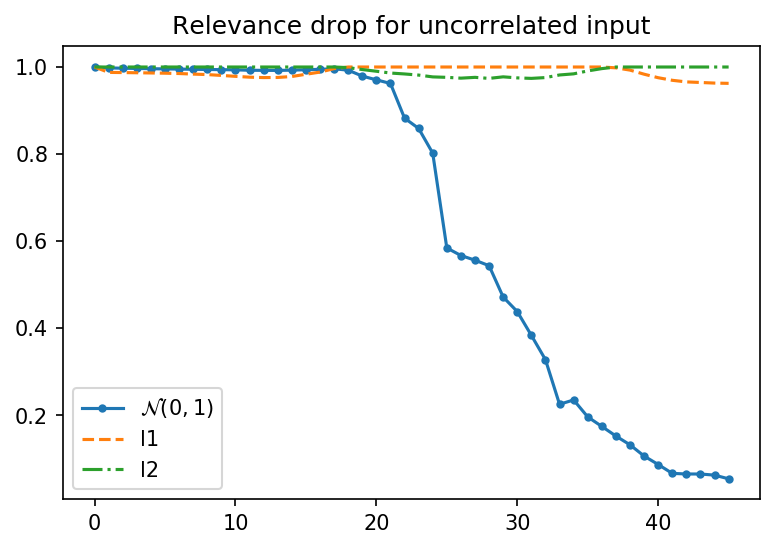

In [62]:
fig = plt.figure('Relevance')
fig.set_dpi(150)
ax = plt.gca()
ax.set_title('Relevance drop for uncorrelated input')
plt.plot(hR.R_epoch[0], '.-',label='$\mathcal{N}(0,1)$')
plt.plot(hR.R_epoch[1], '--',label='l1')
plt.plot(hR.R_epoch[2], '-.',label='l2')
plt.legend()

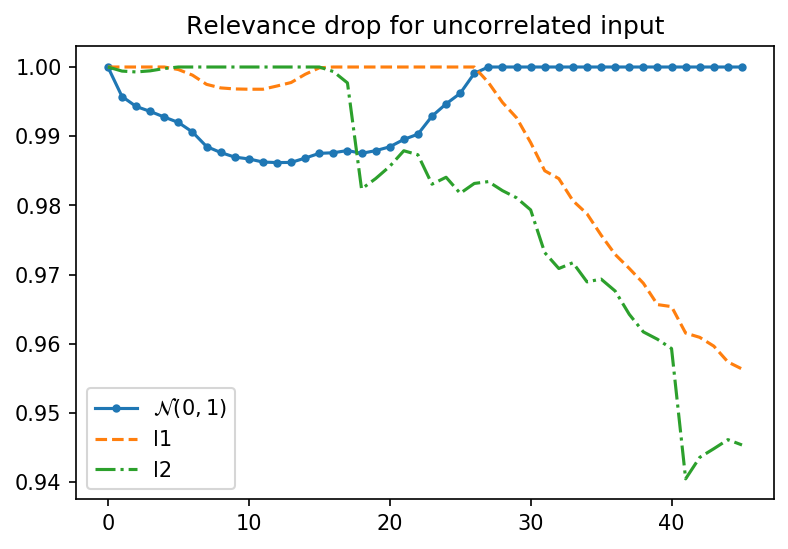

In [113]:
fig = plt.figure('Relevance')
fig.set_dpi(150)
ax = plt.gca()
ax.set_title('Relevance drop for uncorrelated input')
plt.plot(hR.R_epoch[0], '.-',label='$\mathcal{N}(0,1)$')
plt.plot(hR.R_epoch[1], '--',label='l1')
plt.plot(hR.R_epoch[2], '-.',label='l2')
plt.legend()

# :-(

<BarContainer object of 30 artists>

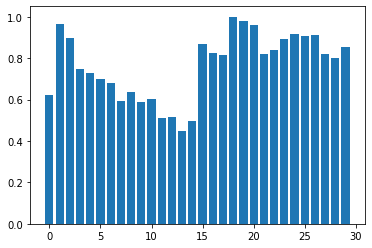

In [63]:
R = vae.generative_net.layers[0].weights
R = R[0].numpy()

Ri = vae.inference_net.layers[1].weights[0].numpy()
plt.bar(range(len(Ri)),Ri)
